# Vanilla Generative Adversarial Network


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [3]:
batch_size= 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5), std = (0.5))])

train_set = MNIST('./data/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [4]:
img, _ = next(iter(train_loader))
print(img.shape)

torch.Size([100, 1, 28, 28])


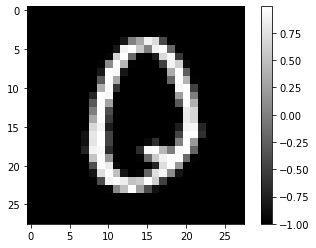

In [5]:
# Example: Normalized image. Values in [-1,1]
shw = plt.imshow(img[0].permute(1,2,0), cmap='gray')
plt.colorbar(shw)
plt.show()

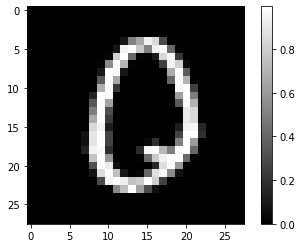

In [6]:
# Example: Denormalized image. Values in [0,1]
def denormalize(x):
    x = (x + 1) / 2
    return x

shw = plt.imshow(denormalize(img[0].permute(1,2,0)), cmap='gray')
plt.colorbar(shw)
plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, input_channels=64, output_channels=1, hidden_channels=64):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(input_channels, hidden_channels * 4, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels * 4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels * 4, hidden_channels * 2 , kernel_size=4, stride=1),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels * 2, hidden_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(hidden_channels, output_channels, kernel_size=4, stride=2),
            nn.Tanh())

    def forward(self, x):
        # x: [batch_size, channels=latent_dimension, width=1, height=1]
        return self.generator(x)
        # [batch_size, channels=1, width=28, height=28]

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=16):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(4,), stride=(2,)),
            nn.BatchNorm2d(hidden_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels, hidden_channels * 2, kernel_size=(3,), stride=(2,)),
            nn.BatchNorm2d(hidden_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels * 2, hidden_channels * 4, kernel_size=(4,), stride=(1,)),
            nn.BatchNorm2d(hidden_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hidden_channels * 4, 1, kernel_size=(3,), stride=(2,)))

    def forward(self, x):
        return self.discriminator(x)

In [9]:
def noise_generator(batch_size, latent_size):
    return torch.randn(batch_size, latent_size).to(device)

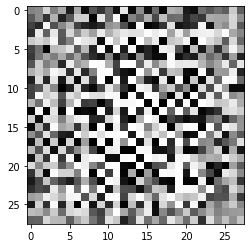

In [10]:
# Testing Generator
generator = Generator(input_channels = 64,  # latent_size
                      output_channels = 1,  # Number of channels of the image
                      hidden_channels = 64).to(device)

noise_vector = noise_generator(1, 64)
# noise_vector: [1, 64]
noise_vector = noise_vector.view(1, 64, 1, 1)
# noise_vector: [batch_size, channels=latent_dimension, width=1, height=1]
fake_img = generator(noise_vector)
# fake_img: [batch_size, channels=1, width=28, height=28]
fake_img = denormalize(fake_img.detach().cpu().permute(0, 2, 3, 1))
plt.imshow(fake_img[0], cmap='gray')
plt.show()